<a href="https://colab.research.google.com/github/jesusrevilla/mineria-de-datos/blob/main/primer-parcial/05_Correlacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minería de Datos: **Correlación** con pandas (Google Colab)

**Objetivo:** Entender y aplicar correlaciones (Pearson, Spearman, Kendall) en un dataset real utilizando `pandas`.


## 🧠 Teoría
- **Correlación**: fuerza y dirección de la relación entre dos variables.
  - **Pearson (r)**: relación **lineal** entre variables numéricas; sensible a outliers.
  - **Spearman (ρ)**: correlación de **rangos**; capta relaciones **monótonas**.
  - **Kendall (τ)**: basado en pares concordantes/discordantes; útil con datos ordinales.
- **Buenas prácticas**: Visualiza (scatter/pairplot), trata faltantes y atípicos, y recuerda que **correlación no implica causalidad**.


## 🎯 Objetivos de aprendizaje
1. Comprender qué miden **Pearson**, **Spearman** y **Kendall** y cuándo usar cada uno.
2. Calcular y visualizar **matrices de correlación** con `pandas` y `seaborn`.
3. Detectar **multicolinealidad** con **VIF** y tomar decisiones.
4. Tratar **faltantes** y **atípicos** que sesgan la correlación.
5. Extraer **insights** para modelado y toma de decisiones.

In [1]:
# # Minería de Datos: Correlación con pandas (Colab)
# Objetivo: entender y aplicar correlaciones (Pearson, Spearman, Kendall) en un dataset real.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr, kendalltau
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: f'{x:.3f}')


In [2]:
# Cargar dataset de pingüinos desde seaborn
df = sns.load_dataset("penguins")

print("Dimensiones:", df.shape)
display(df.head())
display(df.describe(include='all'))


Dimensiones: (344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100,18.700,181.000,3750.000,Male
1,Adelie,Torgersen,39.500,17.400,186.000,3800.000,Female
2,Adelie,Torgersen,40.300,18.000,195.000,3250.000,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.700,19.300,193.000,3450.000,Female


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000,342.000,342.000,342.000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.922,17.151,200.915,4201.754,NaN
std,NaN,NaN,5.460,1.975,14.062,801.955,NaN
min,NaN,NaN,32.100,13.100,172.000,2700.000,NaN
25%,NaN,NaN,39.225,15.600,190.000,3550.000,NaN
50%,NaN,NaN,44.450,17.300,197.000,4050.000,NaN
75%,NaN,NaN,48.500,18.700,213.000,4750.000,NaN


In [5]:
# Limpieza básica: faltantes, duplicados, tipos
faltantes = df.isna().sum().sort_values(ascending=False)
print("Faltantes por columna:")
print(faltantes)

# Eliminar duplicados si los hubiera
antes = df.shape[0]
df = df.drop_duplicates().copy()
despues = df.shape[0]
print(f"Duplicados eliminados: {antes - despues}")

# Imputación simple
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

print("Faltantes restantes:", int(df.isna().sum().sum()))


Faltantes por columna:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64
Duplicados eliminados: 0
Faltantes restantes: 0


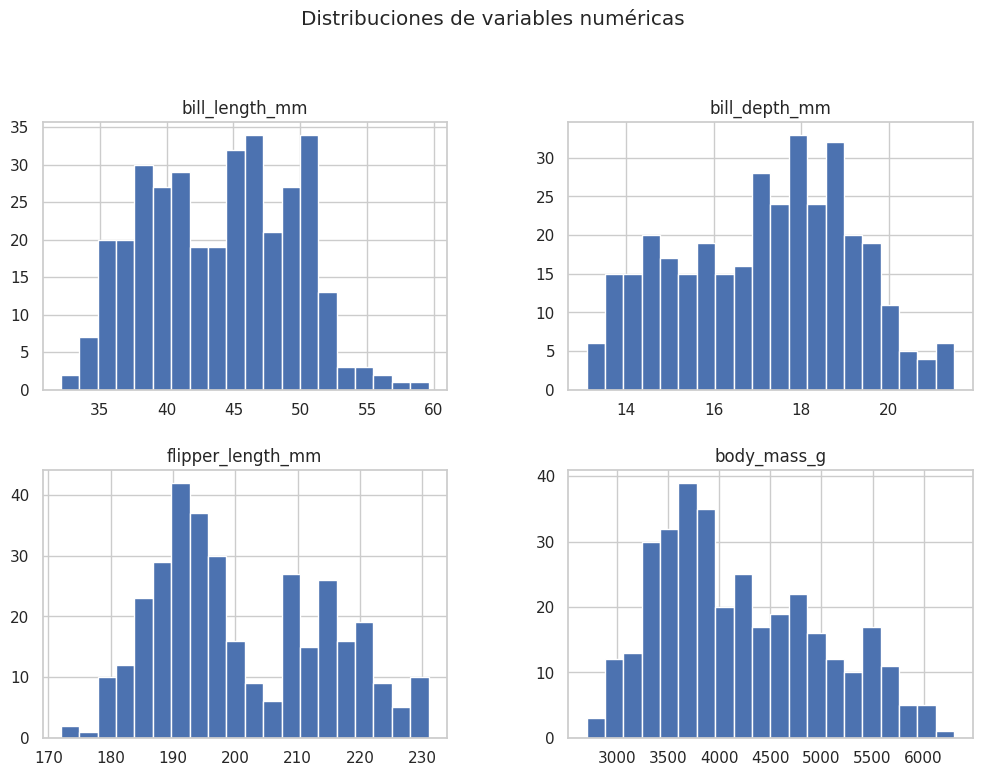

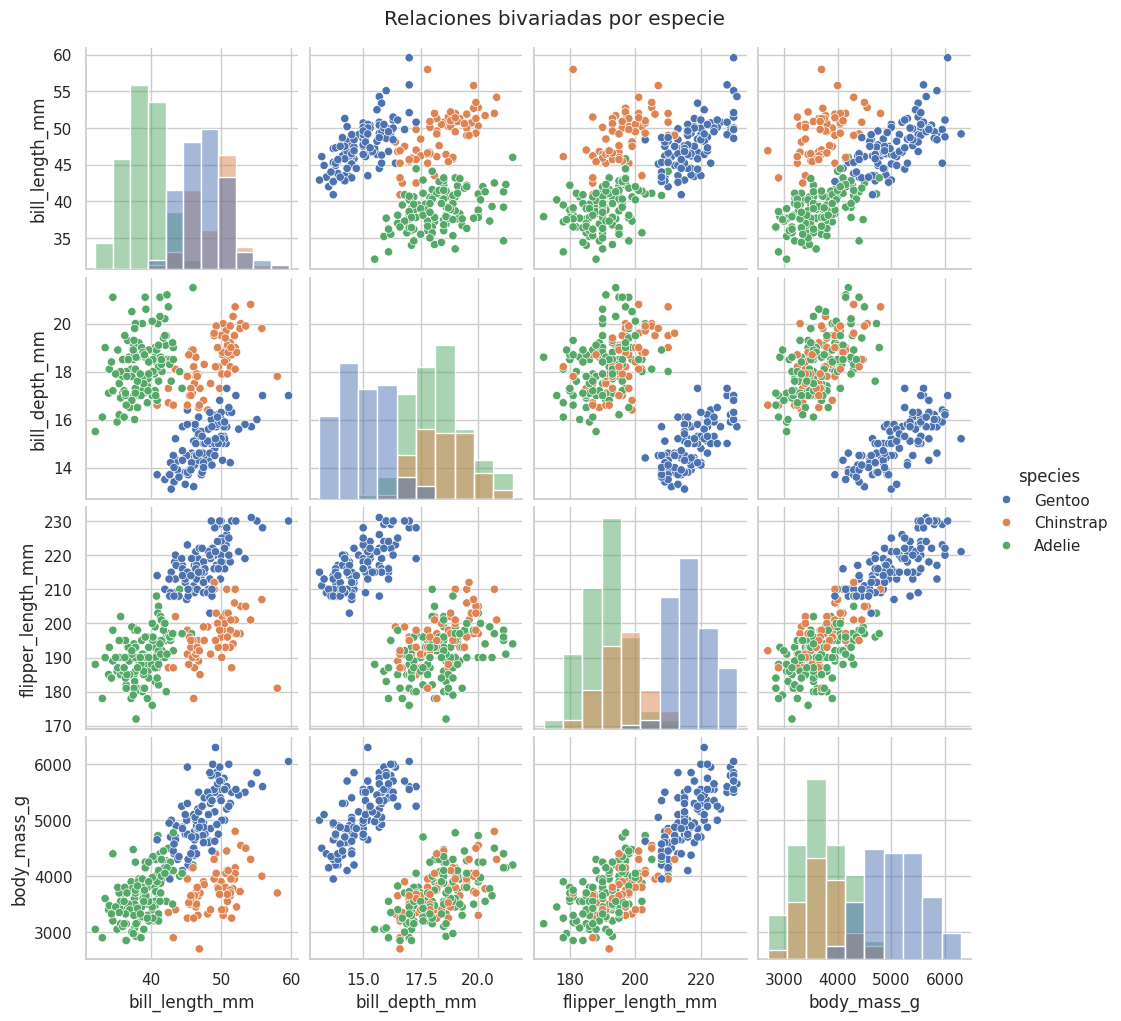

In [6]:
# Exploración visual rápida
df[num_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribuciones de variables numéricas", y=1.02)
plt.show()

sns.pairplot(df.sample(min(300, len(df))), vars=num_cols, hue="species", diag_kind="hist")
plt.suptitle("Relaciones bivariadas por especie", y=1.02)
plt.show()


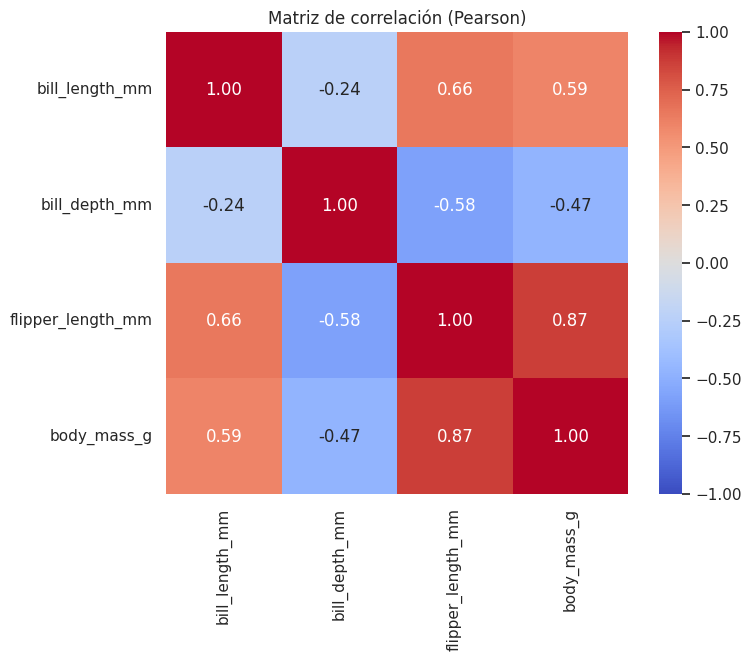

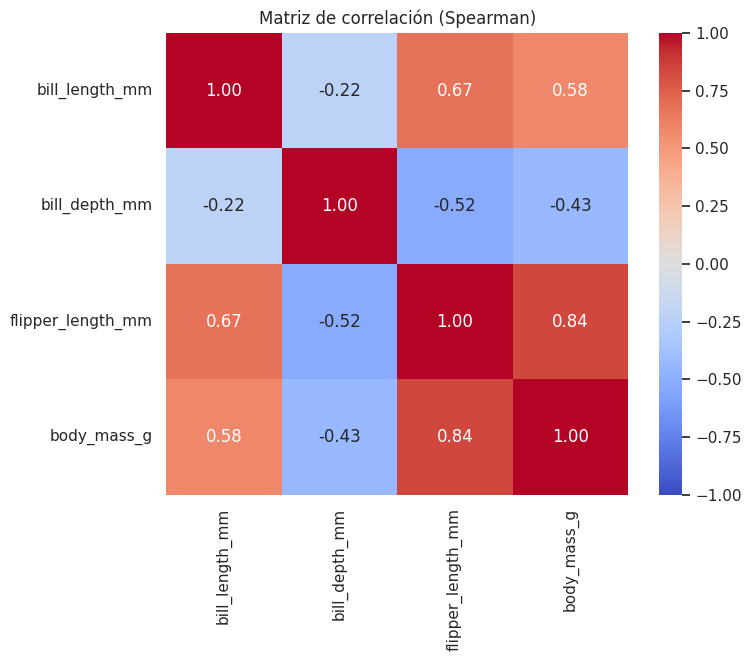

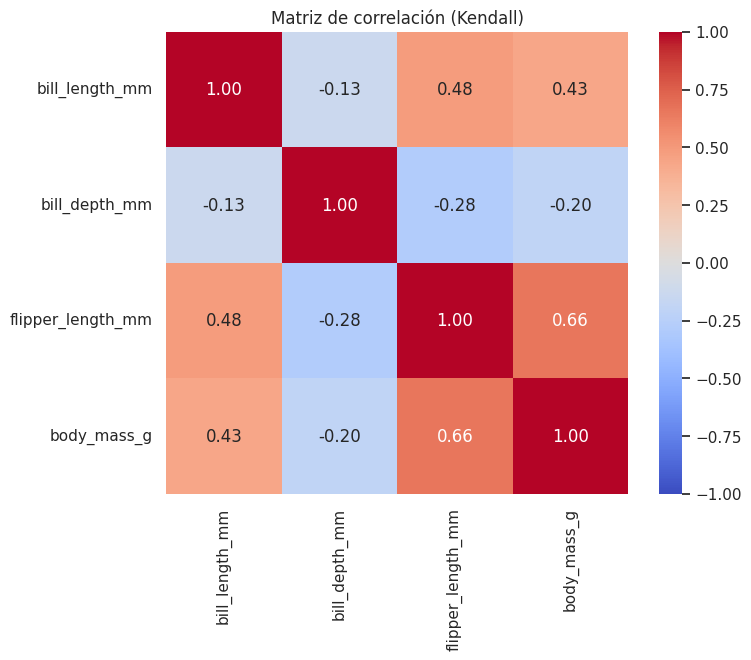

In [7]:
# Matrices de correlación (Pearson, Spearman, Kendall)
corr_pearson = df[num_cols].corr(method="pearson")
corr_spearman = df[num_cols].corr(method="spearman")
corr_kendall = df[num_cols].corr(method="kendall")

def plot_corr_heatmap(corr, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, fmt=".2f")
    plt.title(title)
    plt.show()

plot_corr_heatmap(corr_pearson, "Matriz de correlación (Pearson)")
plot_corr_heatmap(corr_spearman, "Matriz de correlación (Spearman)")
plot_corr_heatmap(corr_kendall, "Matriz de correlación (Kendall)")


In [8]:
# Correlaciones puntuales con significancia
x = df["bill_length_mm"]
y = df["body_mass_g"]

r_p, p_p = pearsonr(x, y)
r_s, p_s = spearmanr(x, y)
r_k, p_k = kendalltau(x, y)

print(f"Pearson r={r_p:.3f}, p-valor={p_p:.4g}")
print(f"Spearman ρ={r_s:.3f}, p-valor={p_s:.4g}")
print(f"Kendall τ={r_k:.3f}, p-valor={p_k:.4g}")


Pearson r=0.595, p-valor=2.6e-34
Spearman ρ=0.584, p-valor=8.569e-33
Kendall τ=0.433, p-valor=1.319e-32


Sin outlier -> Pearson: 0.595, Spearman: 0.584
Con outlier -> Pearson: 0.576, Spearman: 0.593


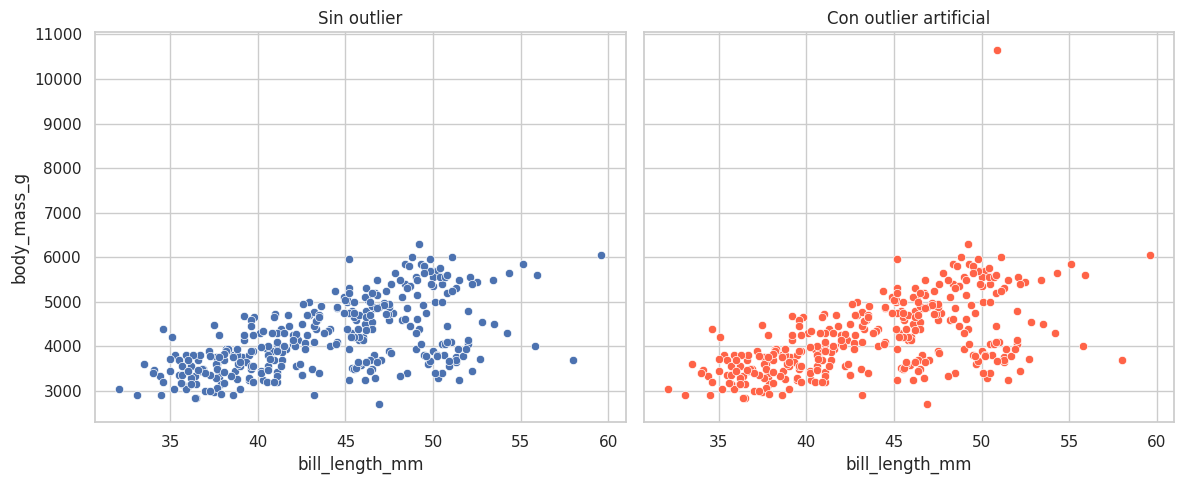

In [9]:
# Efecto de atípicos (outliers) en Pearson vs Spearman
df_out = df.copy()
df_out.loc[df_out.sample(1, random_state=42).index, "body_mass_g"] *= 3

r_p_o, _ = pearsonr(df_out["bill_length_mm"], df_out["body_mass_g"])
r_s_o, _ = spearmanr(df_out["bill_length_mm"], df_out["body_mass_g"])

print(f"Sin outlier -> Pearson: {r_p:.3f}, Spearman: {r_s:.3f}")
print(f"Con outlier -> Pearson: {r_p_o:.3f}, Spearman: {r_s_o:.3f}")

fig, axs = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)
sns.scatterplot(x=df["bill_length_mm"], y=df["body_mass_g"], ax=axs[0])
axs[0].set_title("Sin outlier")
sns.scatterplot(x=df_out["bill_length_mm"], y=df_out["body_mass_g"], ax=axs[1], color="tomato")
axs[1].set_title("Con outlier artificial")
for ax in axs:
    ax.set_xlabel("bill_length_mm")
    ax.set_ylabel("body_mass_g")
plt.tight_layout()
plt.show()


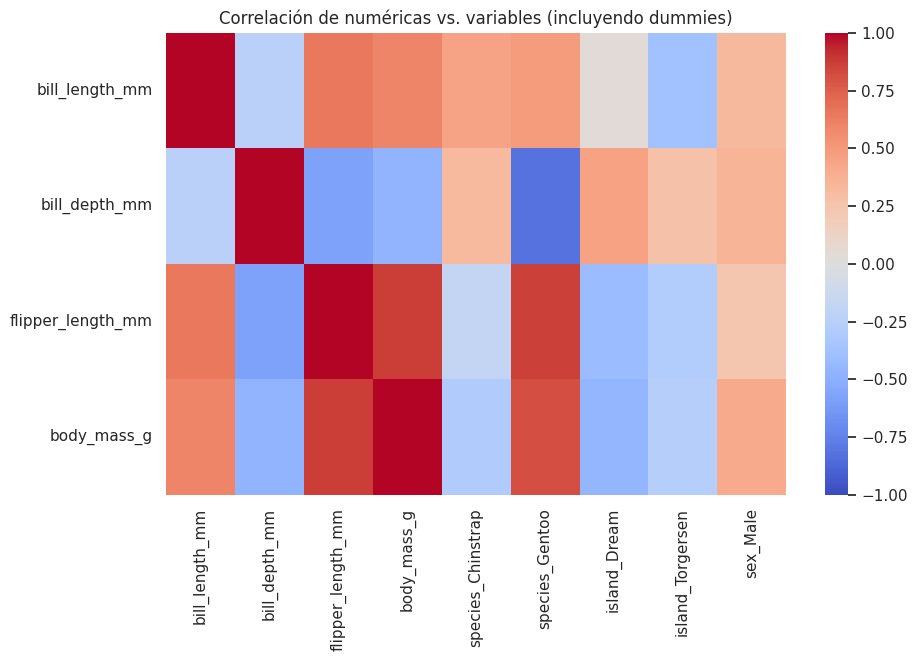

In [10]:
# Correlación con variables categóricas mediante one-hot encoding
df_enc = pd.get_dummies(df, columns=[c for c in df.columns if c in (set(df.columns) - set(df.select_dtypes(include=[np.number]).columns))], drop_first=True)
corr_all = df_enc.corr(method="pearson")
# Seleccionamos columnas originales numéricas para filas
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
def plot_corr_heatmap(corr, title):
    plt.figure(figsize=(10, max(6, len(num_cols)*0.6)))
    sns.heatmap(corr, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

subset = corr_all.loc[num_cols]  # filas: numéricas; columnas: todas (incluye dummies)
plot_corr_heatmap(subset, "Correlación de numéricas vs. variables (incluyendo dummies)")


In [12]:
# Correlación parcial entre X e Y controlando variables Z
def partial_corr(x, y, controls, data):
    Xc = sm.add_constant(data[controls])
    model_x = sm.OLS(data[x], Xc).fit()
    model_y = sm.OLS(data[y], Xc).fit()
    rx = model_x.resid
    ry = model_y.resid
    r, p = pearsonr(rx, ry)
    return r, p

r_partial, p_partial = partial_corr("bill_length_mm", "body_mass_g",
                                    controls=["flipper_length_mm", "bill_depth_mm"],
                                    data=df)
print(f"Correlación parcial (controles: flipper_length_mm, bill_depth_mm): r={r_partial:.3f}, p={p_partial:.4g}")


Correlación parcial (controles: flipper_length_mm, bill_depth_mm): r=0.043, p=0.4298


In [14]:
# Reporte: top pares por |correlación| en Pearson
corr_pearson = df.select_dtypes(include=[np.number]).corr(method="pearson")
corr_abs = corr_pearson.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"level_0": "var1", "level_1": "var2", 0: "abs_corr"})
)
display(top_pairs.head(10))

print('''
Guía de interpretación:
- |r| ~ 0.1: débil; ~0.3: moderada; >=0.5: fuerte (reglas generales).
- Pearson: lineal; sensible a outliers y escala.
- Spearman/Kendall: monótonas; más robustas; no requieren normalidad.
- Correlación ≠ causalidad. Considera confusores y el dominio del problema.
- En modelado, revisa multicolinealidad (VIF) para eliminar/combinar variables.''')


,var1,var2,abs_corr
0,flipper_length_mm,body_mass_g,0.871
1,bill_length_mm,flipper_length_mm,0.656
2,bill_length_mm,body_mass_g,0.595
3,bill_depth_mm,flipper_length_mm,0.584
4,bill_depth_mm,body_mass_g,0.472
5,bill_length_mm,bill_depth_mm,0.235



Guía de interpretación:
- |r| ~ 0.1: débil; ~0.3: moderada; >=0.5: fuerte (reglas generales).
- Pearson: lineal; sensible a outliers y escala.
- Spearman/Kendall: monótonas; más robustas; no requieren normalidad.
- Correlación ≠ causalidad. Considera confusores y el dominio del problema.
- En modelado, revisa multicolinealidad (VIF) para eliminar/combinar variables.
